In [ ]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



0: 640x544 1 head, 299.1ms
Speed: 5.6ms preprocess, 299.1ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 544)


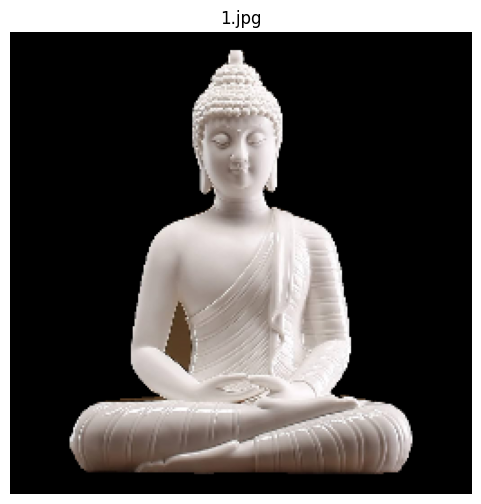


0: 448x640 1 head, 254.3ms
Speed: 4.0ms preprocess, 254.3ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)


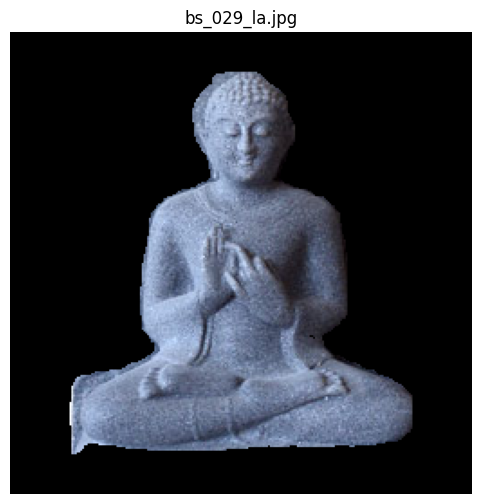


0: 448x640 1 head, 247.5ms
Speed: 3.9ms preprocess, 247.5ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


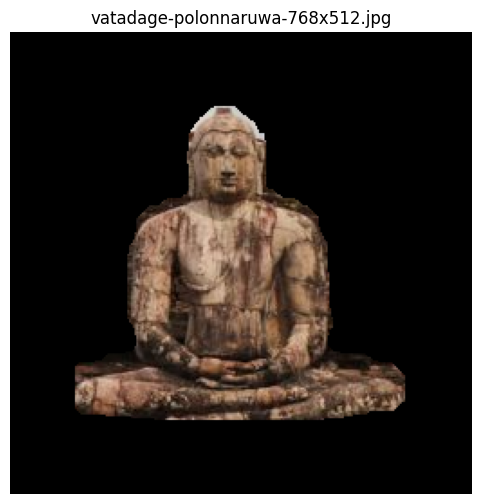


0: 640x480 1 head, 237.5ms
Speed: 6.2ms preprocess, 237.5ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


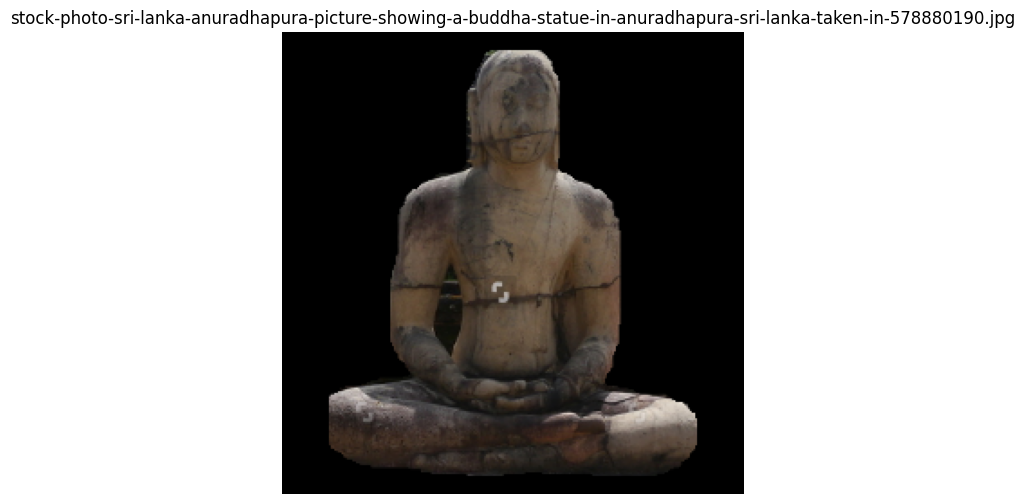


0: 448x640 1 head, 241.8ms
Speed: 4.6ms preprocess, 241.8ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)


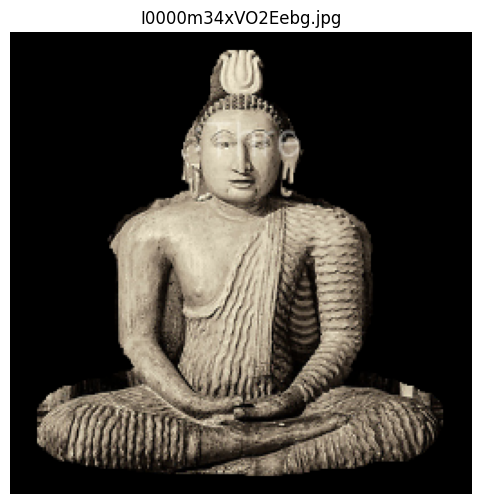


0: 640x640 1 head, 388.3ms
Speed: 4.6ms preprocess, 388.3ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)


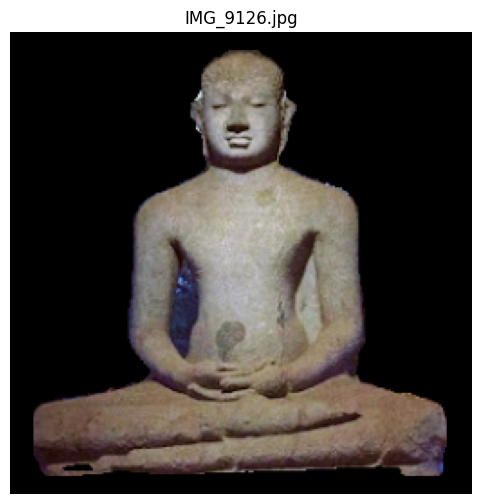

In [ ]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

#Locate the model path and image dir path
#Output folder will contains all the generated outputs
#Image size is the output image size (In this case, 256x256)
model_path = '/content/drive/MyDrive/Colab Notebooks/Object Segmentation/Model_Training/runs/segment/train/weights/best.pt'
image_folder = '/content/drive/MyDrive/Colab Notebooks/Object Segmentation/test/'
output_folder = './output/'
image_size = 256
padding = 10

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

model = YOLO(model_path)

def visualize_image(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)
    if img is None:
        continue

    H, W, _ = img.shape
    results = model(img)

    for result in results:
        for j, mask in enumerate(result.masks.data):
            mask = mask.cpu().numpy()
            mask_resized = cv2.resize(mask, (W, H))
            mask_resized = (mask_resized > 0.5).astype(np.uint8)
            cropped_img = cv2.bitwise_and(img, img, mask=mask_resized)
            contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            x, y, w, h = cv2.boundingRect(contours[0])
            cropped_img = cropped_img[y:y+h, x:x+w]

            max_dim = image_size - 2 * padding
            if w > max_dim or h > max_dim:
                scale = min(max_dim / w, max_dim / h)
                cropped_img = cv2.resize(cropped_img, (int(w * scale), int(h * scale)))
                w, h = cropped_img.shape[1], cropped_img.shape[0]

            canvas = np.zeros((image_size, image_size, 3), dtype=np.uint8)
            start_x = (image_size - w) // 2
            start_y = (image_size - h) // 2
            canvas[start_y:start_y+h, start_x:start_x+w] = cropped_img

            output_path = os.path.join(output_folder, f'{os.path.splitext(image_name)[0]}.png')
            cv2.imwrite(output_path, canvas)

            # Visualize the output image
            visualize_image(canvas, title = image_name)